# Summary
I have had some success developing a model predict which NHL players would be inducted into the hockey Hall of Fame.

However, the classes of players that get into the hall of fame versus not are completely unbalanced.  I need to oversample the hall of fame players or undersample the non-hall of famers to get a better accuarcy.

# Problem Understanding
The problem I am trying to solve is to **predict which NHL hockey players will be inducted into the hockey Hall of Fame**.

For this research, I'm focusing the scope on just the non-goalie players.

The prediction likely is based on a hockey player's career performance.  Performance can be measured in a number of different ways including goals, assists, points, and awards received.

# Data Understanding
The data I'll be using for this analysis is from the [Professional Hockey Database](https://www.kaggle.com/open-source-sports/professional-hockey-database).  It includes data on a players hall of fame status, points, awards given.

There are several limitations with the dataset:
* The latest year is 2011.  However, the dataset may have enough data to help make accurate predictions for players who have inducted into the hall of fame after 2011.
* I have noted that many players that played after 2011 have been marked as their last NHL year is 2011.   I've made the assumption that if a player's last year is recorded as 2011 then I indicate that they are current players and not included in fitting the prediction.

![](https://images.rawpixel.com/image_800/czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvZmw0NzEyMjE2NTM4Mi1pbWFnZS1rdTI1OG13OS5qcGc.jpg)

# Python Libraries

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

# Data Integration: Extract, Transform, Load (ETL)

## Data Extract
The data is extracted

In [2]:
#Have Pandas output more columns 
pd.set_option('display.max_columns', 30)

#Data Import
master = pd.read_csv("../input/Master.csv")
awardsPlayers = pd.read_csv("../input/AwardsPlayers.csv")
scoring = pd.read_csv("../input/Scoring.csv")
scoringSC = pd.read_csv("../input/ScoringSC.csv")
hof = pd.read_csv("../input/HOF.csv")

## Data Preprocessing Transformations
The data is preprocessed and then a subset is displayed as example of what is in the dataset.

In [3]:
class PlayersWithCareerStartDates(BaseEstimator, TransformerMixin):
    """Subset only players who have career start dates"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[(X.playerID.notnull()) & (X.firstNHL.notnull() | X.firstWHA.notnull())]

class AddIndicators(BaseEstimator, TransformerMixin):
    """Add indicators"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #Add Retired indicator
        X.loc[:, 'retired'] = 1
        X.loc[X.lastNHL == 2011, 'retired'] = 0
        #Add Hall of Fame indicator
        X['hof'] = 0
        X.loc[X.hofyear.notnull(), 'hof'] = 1
        #Add Goalie indicator
        X['goalie'] = 0
        X.loc[X.pos == "G", 'goalie'] = 1
        #Return Dataset
        return X
    
class MergeOtherData(BaseEstimator, TransformerMixin):
    """Merge Players, aggregate sum of points, Counts for All Awards, and Hall of Fame Status by outer join"""
    def __init__(self, score, award, hall):
        self.score = score
        self.award = award
        self.hall = hall
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #Count of all awards
        awards = self.award.groupby(['playerID']).size().to_frame('awards').reset_index()
        #Sum of all points
        points = self.score[['playerID','Pts']].groupby(['playerID']).sum().reset_index()
        #Merge Players, aggregate sum of points, Counts for All Awards, and Hall of Fame Status by outer join
        X = X.merge(points, left_on='playerID', right_on='playerID', how='left')
        X = X.merge(awards, left_on='playerID', right_on='playerID', how='left')
        X = X.merge(self.hall, left_on='hofID', right_on='hofID', how='left')
        #Rename columns
        X=X.rename(columns = {'year':'hofyear'})
        X=X.rename(columns = {'Pts':'pts'})
        #Assign 0 to variables showing NA as a result of the merge
        X.loc[X.awards.isnull(),'awards'] = 0
        X.loc[X.pts.isnull(),'pts'] = 0
        #Return dataset
        return X
    
class AddPlayersInductedToHOFSince(BaseEstimator, TransformerMixin):
    """Add Years to all players inducted in 2012 and onwards"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        hof = [
            {"firstName":"Pavel", "lastName":"Bure", "hofyear":2012},
            {"firstName":"Adam", "lastName":"Oates", "hofyear":2012},
            {"firstName":"Joe", "lastName":"Sakic", "hofyear":2012},
            {"firstName":"Mats", "lastName":"Sundin", "hofyear":2012},
            {"firstName":"Chris", "lastName":"Chelios", "hofyear":2013},
            {"firstName":"Scott", "lastName":"Niedermayer", "hofyear":2013},
            {"firstName":"Brendan", "lastName":"Shanahan", "hofyear":2013},
            {"firstName":"Rob", "lastName":"Blake", "hofyear":2014},
            {"firstName":"Peter", "lastName":"Forsberg", "hofyear":2014},
            {"firstName":"Mike", "lastName":"Modano", "hofyear":2014},
            {"firstName":"Sergei", "lastName":"Fedorov", "hofyear":2015},
            {"firstName":"Phil", "lastName":"Housley", "hofyear":2015},
            {"firstName":"Nicklas", "lastName":"Lidstrom", "hofyear":2015},
            {"firstName":"Chris", "lastName":"Pronger", "hofyear":2015},
            {"firstName":"Eric", "lastName":"Lindros", "hofyear":2016},
            {"firstName":"Dave", "lastName":"Andreychuk", "hofyear":2017},
            {"firstName":"Paul", "lastName":"Kariya", "hofyear":2017},
            {"firstName":"Mark", "lastName":"Recchi", "hofyear":2017},
            {"firstName":"Teemu", "lastName":"Selanne", "hofyear":2017},
            {"firstName":"Martin", "lastName":"St. Louis", "hofyear":2018},
        ]
        for i in hof:
            X.loc[(X.firstName == i["firstName"]) & (X.lastName == i["lastName"]), 'hofyear'] = i["hofyear"]
        return X
    
class VariablesToKeep(BaseEstimator, TransformerMixin):
    """Keep only relevant columns"""
    def __init__(self, variables):
        self.variables = variables
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.variables]
    
class RetiredPlayers(BaseEstimator, TransformerMixin):
    """Output only Retired Players"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[X.retired == 1]
    
class NonRetiredPlayers(BaseEstimator, TransformerMixin):
    """Output only Non-Retired Players"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[X.retired == 0]

class NonGoalies(BaseEstimator, TransformerMixin):
    """Output only non-Goalies"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[players.goalie != 1]
    
class PlayersPredictedHOF(BaseEstimator, TransformerMixin):
    """Players predicted to be in Hall of Fame"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X.loc[(X.hofyear > 2011) | (X.hofyear.isnull() & X.predhof == 1), :]
    
class AddYearsPlayed(BaseEstimator, TransformerMixin):
    """Add years played overall, in NHL, and in WHA"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        #Calculate first year playing
        X.loc[X.firstNHL <= X.firstWHA, 'firstYear'] = X.firstNHL
        X.loc[X.firstNHL >= X.firstWHA, 'firstYear'] = X.firstWHA
        X.loc[X.firstNHL.isnull(), 'firstYear'] = X.firstWHA
        X.loc[X.firstWHA.isnull(), 'firstYear'] = X.firstNHL
        #Calculate last year playing
        X.loc[X.lastNHL >= X.lastWHA, 'lastYear'] = X.lastNHL
        X.loc[X.lastNHL <= X.lastWHA, 'lastYear'] = X.lastWHA
        X.loc[X.lastNHL.isnull(), 'lastYear'] = X.lastWHA
        X.loc[X.lastWHA.isnull(), 'lastYear'] = X.lastNHL
        #Calculate total years playing
        X.loc[:, 'yearsPlayed'] = X.lastYear-X.firstYear+1
        #Calculate total years playing in one league
        X.loc[:, 'yearsPlayedNHL'] = 0
        X.loc[:, 'yearsPlayedWHA'] = 0
        X.loc[X.firstNHL.notnull(), 'yearsPlayedNHL'] = X.lastNHL-X.firstNHL+1
        X.loc[X.firstWHA.notnull(), 'yearsPlayedWHA'] = X.lastWHA-X.firstWHA+1
        X.loc[(X.lastNHL >= X.lastWHA) & (X.firstNHL <= X.firstWHA), 'yearsPlayedNHL'] = X.lastNHL-X.firstNHL+1-X.yearsPlayedWHA
        X.loc[(X.lastWHA >= X.lastNHL) & (X.firstWHA <= X.firstNHL), 'yearsPlayedNHL'] = X.lastWHA-X.firstWHA+1-X.yearsPlayedNHL
        return X

class AddEraIndicator(BaseEstimator, TransformerMixin):
    """Add era of the player"""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        eras = ["Founding 1917-1941","Original Six 1942-1967","Expansion 1968-1992","Modern 1993-"]
        X['era'] = pd.cut(X.lastYear, [1917,1941,1967,1992,2011], labels=eras, include_lowest=True)
        X['era_temp'] = X['era']
        X = pd.get_dummies(X, columns=["era_temp"], prefix="era")
        return X
    
variableList = ["firstName","lastName","firstNHL","lastNHL","firstWHA","lastWHA","pos","goalie","birthYear","deathYear","retired","awards","pts","hofyear","hof"]
    
dataPipe = Pipeline([
    ('playersWithCareerStartDates', PlayersWithCareerStartDates()),
    ('mergeOtherData', MergeOtherData(scoring, awardsPlayers, hof)),
    ('addPlayersInductedToHOFSince', AddPlayersInductedToHOFSince()),
    ('addIndicators', AddIndicators()),
    ('variablesToKeep', VariablesToKeep(variableList)),
    ('addYearsPlayed', AddYearsPlayed()),
    ('addEraIndicator', AddEraIndicator())
])

players = dataPipe.fit_transform(master)

retiredNonGoaliePipe = Pipeline([
    ('retiredPlayers', RetiredPlayers()),
    ('nonGoalies', NonGoalies())
])

retiredNonGoalies = retiredNonGoaliePipe.fit_transform(players)

nonGoalies = NonGoalies().transform(players)

#Sample Players Table
players

/tmp/ipykernel_17/1640253856.py:110: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return X[players.goalie != 1]


,firstName,lastName,firstNHL,lastNHL,firstWHA,lastWHA,pos,goalie,birthYear,deathYear,retired,awards,pts,hofyear,hof,firstYear,lastYear,yearsPlayed,yearsPlayedNHL,yearsPlayedWHA,era,era_Founding 1917-1941,era_Original Six 1942-1967,era_Expansion 1968-1992,era_Modern 1993-
0,Antti,Aalto,1997.0,2000.0,NaN,NaN,C,0,1975.0,NaN,1,0.0,28.0,NaN,0,1997.0,2000.0,4.0,4,0,Modern 1993-,False,False,False,True
1,Bruce,Abbey,NaN,NaN,1975.0,1975.0,D,0,1951.0,NaN,1,0.0,1.0,NaN,0,1975.0,1975.0,1.0,0,1,Expansion 1968-1992,False,False,True,False
2,George,Abbott,1943.0,1943.0,NaN,NaN,G,1,1911.0,NaN,1,0.0,0.0,NaN,0,1943.0,1943.0,1.0,1,0,Original Six 1942-1967,False,True,False,False
3,Reg,Abbott,1952.0,1952.0,NaN,NaN,C,0,1930.0,NaN,1,0.0,0.0,NaN,0,1952.0,1952.0,1.0,1,0,Original Six 1942-1967,False,True,False,False
4,Justin,Abdelkader,2007.0,2011.0,NaN,NaN,L,0,1987.0,NaN,0,0.0,47.0,NaN,0,2007.0,2011.0,5.0,5,0,Modern 1993-,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7290,Jason,Zucker,2011.0,2011.0,NaN,NaN,L,0,1992.0,NaN,0,0.0,2.0,NaN,0,2011.0,2011.0,1.0,1,0,Modern 1993-,False,False,False,True
7291,Mike,Zuke,1978.0,1985.0,1976.0,1977.0,C,0,1954.0,NaN,1,0.0,346.0,NaN,0,1976.0,1985.0,10.0,8,2,Expansion 1968-1992,False,False,True,False
7292,Wayne,Zuk,NaN,NaN,1973.0,1973.0,C,0,1949.0,NaN,1,0.0,0.0,NaN,0,1973.0,1973.0,1.0,0,1,Expansion 1968-1992,False,False,True,False
7293,Rudy,Zunich,1943.0,1943.0,NaN,NaN,D,0,1910.0,1974.0,1,0.0,0.0,NaN,0,1943.0,1943.0,1.0,1,0,Original Six 1942-1967,False,True,False,False


# Exploratory Data Analysis:  Descriptive and Correlation
By investigating the correlationships in the dataset, it was discovered that hall of fame status was correlated with awards and points.  I'm only using retired players for this analysis and it will give a better sense how career stats are related to being inducted to the hall of fame.

## Descriptive Analysis

In [4]:
retiredNonGoalies.describe()

,firstNHL,lastNHL,firstWHA,lastWHA,goalie,birthYear,deathYear,retired,awards,pts,hofyear,hof,firstYear,lastYear,yearsPlayed,yearsPlayedNHL,yearsPlayedWHA
count,5282.000000,5282.000000,804.000000,804.000000,5677.0,5602.000000,1039.000000,5677.0,5677.000000,5677.000000,201.000000,5677.000000,5677.000000,5677.000000,5677.000000,5677.000000,5677.000000
mean,1975.379591,1980.697842,1974.277363,1975.767413,0.0,1953.005177,2525.427334,1.0,0.244143,126.778580,1981.383085,0.035406,1975.238682,1980.469438,6.230756,5.845869,0.352651
std,23.423058,23.830676,2.133510,1.948754,0.0,23.279746,2009.749957,0.0,1.544251,227.224587,19.813317,0.184820,22.598479,22.987779,5.168986,5.217134,1.081264
min,1917.000000,1917.000000,1972.000000,1972.000000,0.0,1879.000000,1918.000000,1.0,0.000000,0.000000,1945.000000,0.000000,1917.000000,1917.000000,1.000000,0.000000,0.000000
25%,1963.000000,1970.000000,1972.000000,1974.000000,0.0,1942.000000,1974.000000,1.0,0.000000,2.000000,1963.000000,0.000000,1967.000000,1973.000000,2.000000,1.000000,0.000000
50%,1981.000000,1986.000000,1974.000000,1976.000000,0.0,1958.000000,1991.000000,1.0,0.000000,27.000000,1981.000000,0.000000,1979.000000,1984.000000,5.000000,4.000000,0.000000
75%,1993.000000,2000.000000,1976.000000,1978.000000,0.0,1970.000000,2003.000000,1.0,0.000000,153.000000,1998.000000,0.000000,1992.000000,1999.000000,10.000000,9.000000,0.000000
max,2010.000000,2010.000000,1978.000000,1978.000000,0.0,1990.000000,9999.000000,1.0,51.000000,2967.000000,2017.000000,1.000000,2010.000000,2010.000000,34.000000,28.000000,7.000000


## Distributions
The pts and awards variables are heavily skewed towards lower totals because most players score and get awarded very few times in a career compared to the top players.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

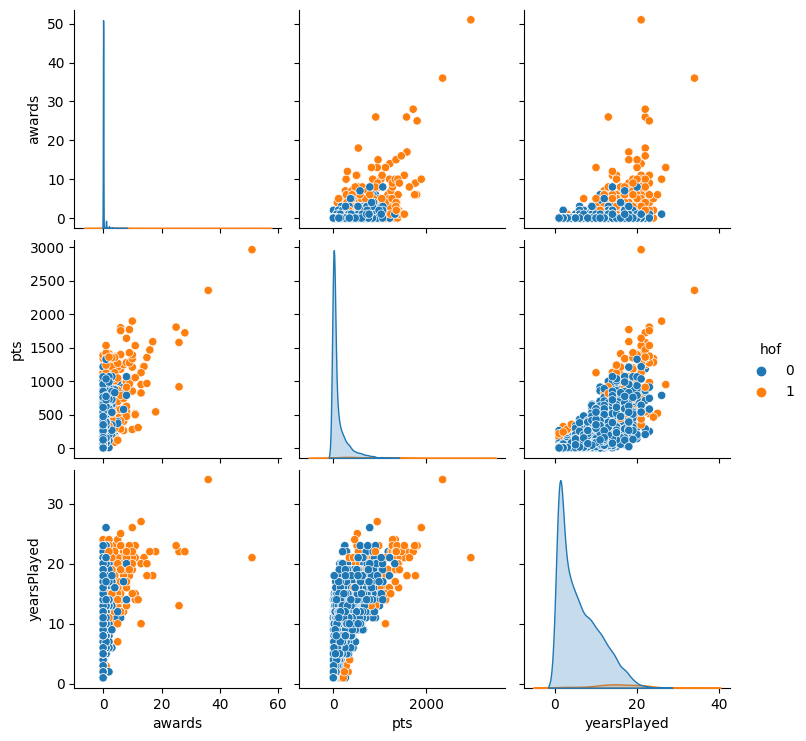

In [5]:
sns.pairplot(retiredNonGoalies, vars=['awards','pts','yearsPlayed'], hue="hof")

## Correlations
Since the bivariate distributions between many of the variables are not normally distributed, a Spearman Rank Correlation is done.

When looking at correlations between variables, it appears that points and awards most correlate strongly with hall of fame status.  Therefore, the modelling will focus on the relationships between the response variable hall of fame status and two predictors:  awards and points.

In [6]:
corr_spearman = retiredNonGoalies.corr(method='spearman', numeric_only=True)
corr_spearman['hof'].sort_values(ascending=False)

hof                           1.000000
awards                        0.517843
pts                           0.263726
yearsPlayedNHL                0.238022
yearsPlayed                   0.233214
era_Founding 1917-1941        0.125711
lastWHA                       0.097416
firstWHA                      0.083809
era_Original Six 1942-1967    0.068317
yearsPlayedWHA               -0.034323
era_Modern 1993-             -0.054689
era_Expansion 1968-1992      -0.065934
lastYear                     -0.108933
lastNHL                      -0.115726
birthYear                    -0.169806
deathYear                    -0.173473
firstYear                    -0.178561
firstNHL                     -0.185873
goalie                             NaN
retired                            NaN
hofyear                            NaN
Name: hof, dtype: float64

## Hall of Fame Indicator
The hall of fame distribution is heavily skewed towards non-hall of famers for obvious reasons:  only the best get into the hall of fame.  In fact, only 3.3% of all players are in the hall of fame.  This is indicative of imbalanced data, which will further complicate modelling.

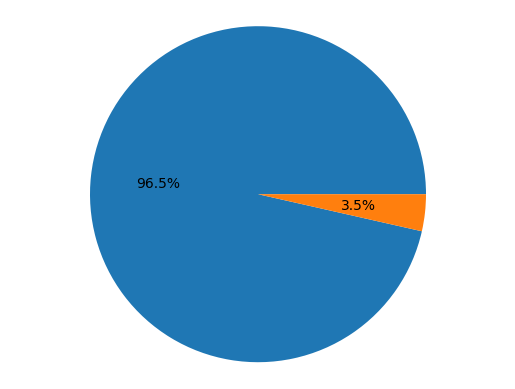

In [7]:
plt.pie(retiredNonGoalies['hof'].value_counts(), autopct='%1.1f%%')
plt.axis('equal')
plt.show()

## Points
The first area of investigation is the relationship of the career number of a hockey player's points - goals and assists - to hall of fame status.

The analysis shows that there is a statistically significant difference in the number of career points between hall of famers and non-hall of famers.

There also appears to be a growing number of points necessary to get into the Hall of Fame over the year.

Some additional future analysis could include t-tests for statistical significance of the points mean between hall of famers and non-hall of famers.

<Axes: xlabel='hof', ylabel='pts'>

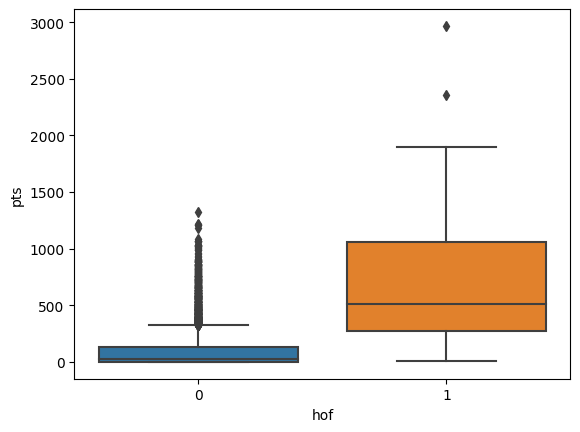

In [8]:
#Plot of points by Hall of Fame status
sns.boxplot(x="hof", y="pts", data=retiredNonGoalies)

In [9]:
sp.stats.ranksums(retiredNonGoalies[retiredNonGoalies["hof"] == 1]['pts'], 
retiredNonGoalies[retiredNonGoalies["hof"] == 0]['pts'])

RanksumsResult(statistic=19.830058331538712, pvalue=1.6384965323736183e-87)

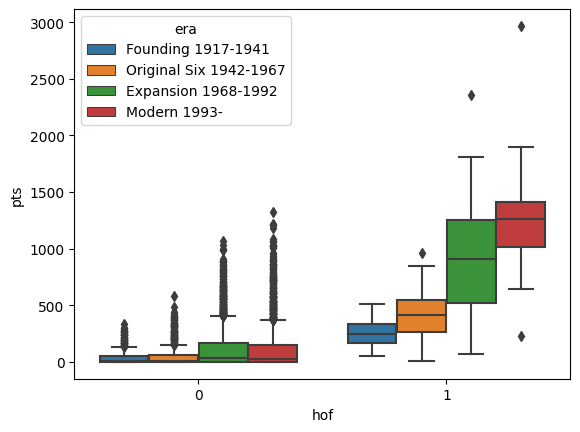

In [10]:
#Boxplot of points by Hall of Fame status and Era
sns.boxplot(x="hof", y="pts", hue="era", data=retiredNonGoalies);

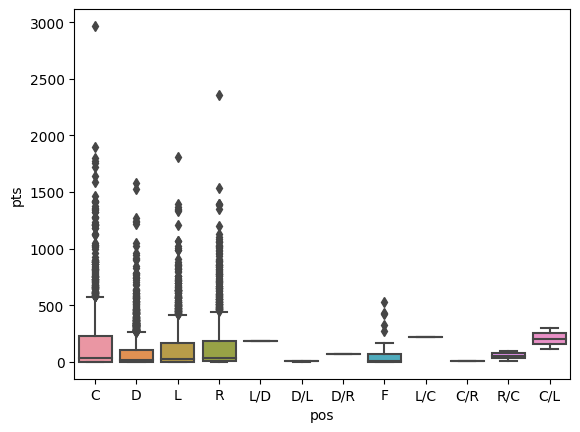

In [11]:
#See if there is any variance in points by position
sns.boxplot(x="pos", y="pts", data=retiredNonGoalies);

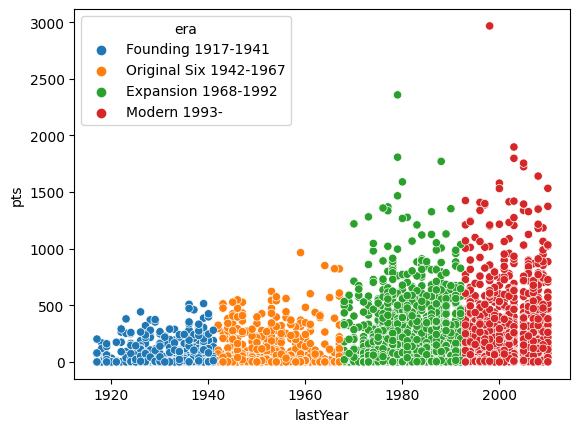

In [12]:
#Plot between Points and era
sns.scatterplot(x="lastYear", y="pts", hue="era", data=retiredNonGoalies);

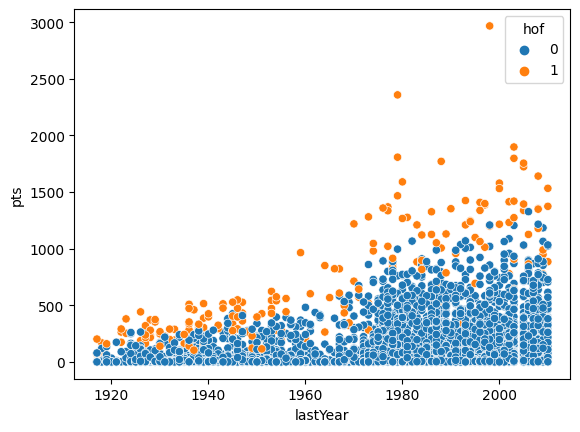

In [13]:
#Plot between Points and Year of last game
sns.scatterplot(x="lastYear", y="pts", hue="hof", data=retiredNonGoalies);

## Awards
Awards also seem to strongly suggest differences between hall of fame and non-hall of fame players.

The number of career awards for those getting in the Hall of Fame is relatively stable over the years.

<Axes: xlabel='hof', ylabel='awards'>

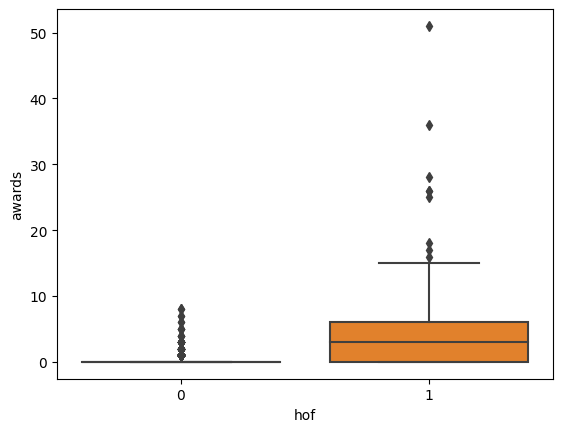

In [14]:
sns.boxplot(data=retiredNonGoalies, y="awards", x="hof")

In [15]:
sp.stats.ranksums(retiredNonGoalies[retiredNonGoalies['hof']==1]['awards'], 
                  retiredNonGoalies[retiredNonGoalies['hof']==0]['awards'])

RanksumsResult(statistic=17.50635482802893, pvalue=1.2814145727528592e-68)

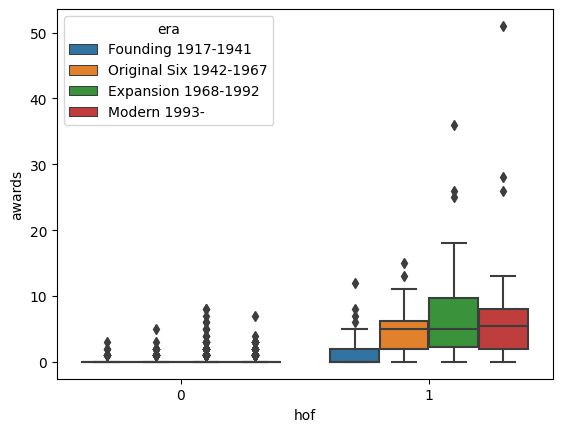

In [16]:
#Awards
sns.boxplot(x="hof", y="awards", hue="era", data=retiredNonGoalies);

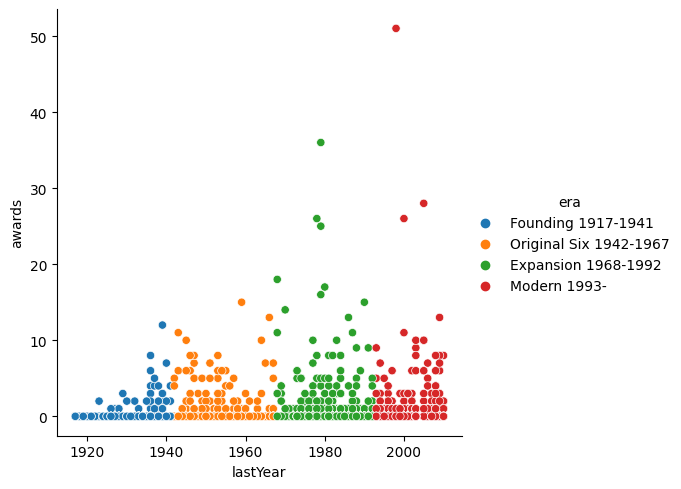

In [17]:
#Plot between Awards and year of last game
sns.relplot(x="lastYear", y="awards", hue="era", data=retiredNonGoalies);

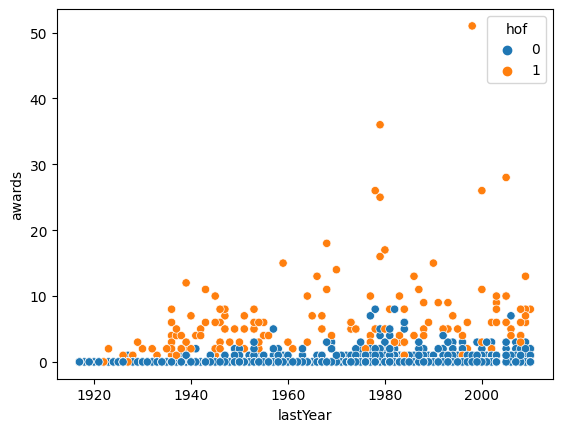

In [18]:
#Plot between Points and Year of last NHL game
sns.scatterplot(x="lastYear", y="awards", hue="hof", data=retiredNonGoalies);

<Axes: title={'center': 'awards'}, xlabel='hof'>

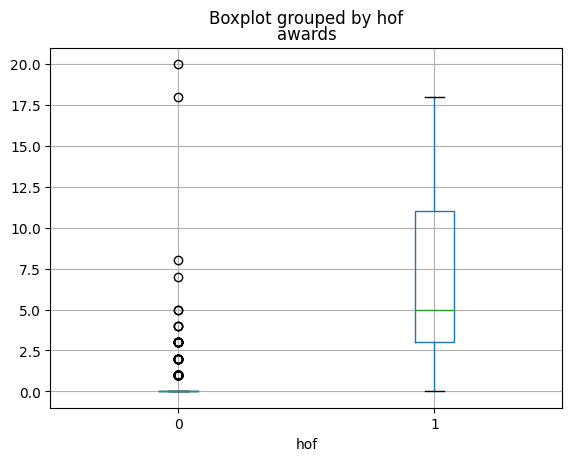

In [19]:
#Awards for Goalies
players[(players.goalie == 1)].boxplot(column='awards', by='hof')

## Points and Awards

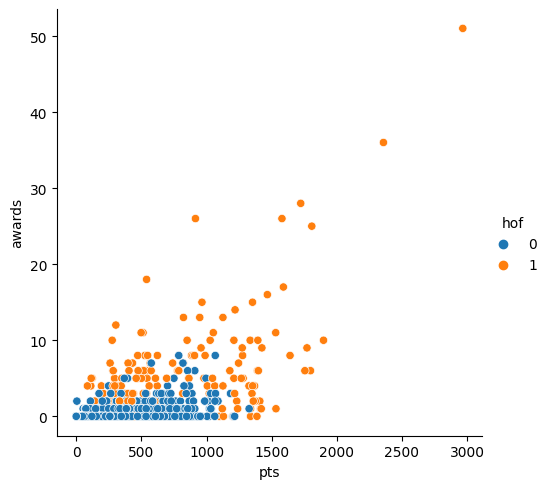

In [20]:
sns.relplot(x="pts", y="awards", hue="hof", data=retiredNonGoalies)

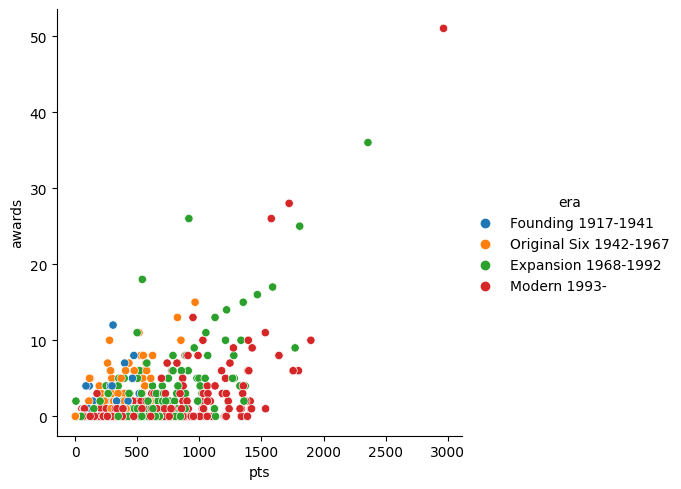

In [21]:
sns.relplot(x="pts", y="awards", hue="era", data=retiredNonGoalies)

## Years played in NHL
There appears to be a difference between the number of years played in the NHL for hall of famers over non-hall of famers.

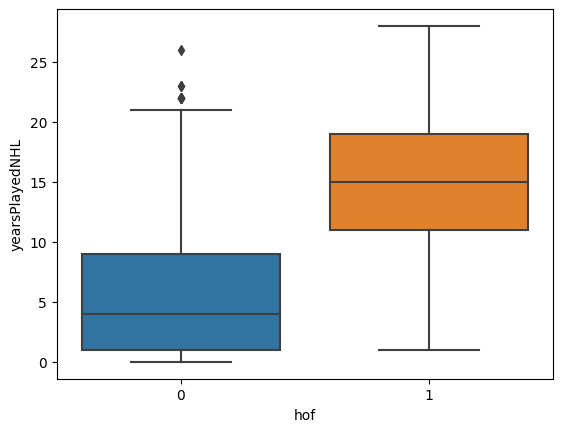

In [22]:
sns.boxplot(x="hof", y="yearsPlayedNHL", data=retiredNonGoalies);

## Years played in WHA

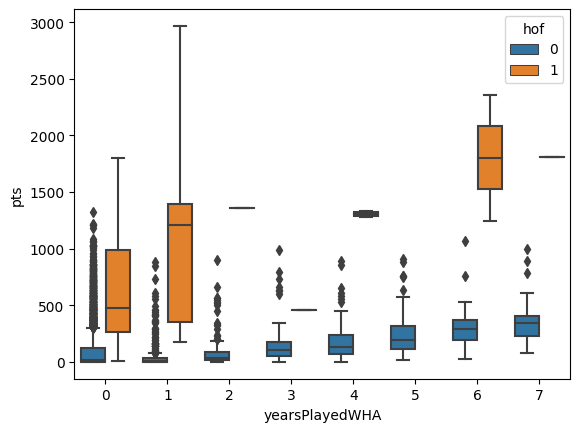

In [23]:
sns.boxplot(x="yearsPlayedWHA", y="pts", hue="hof", data=retiredNonGoalies);

In [24]:
players.loc[(players.yearsPlayedWHA==6) & (players.hof==1),:]

,firstName,lastName,firstNHL,lastNHL,firstWHA,lastWHA,pos,goalie,birthYear,deathYear,retired,awards,pts,hofyear,hof,firstYear,lastYear,yearsPlayed,yearsPlayedNHL,yearsPlayedWHA,era,era_Founding 1917-1941,era_Original Six 1942-1967,era_Expansion 1968-1992,era_Modern 1993-
2868,Gordie,Howe,1946.0,1979.0,1973.0,1978.0,R,0,1928.0,NaN,1,36.0,2358.0,1972.0,1,1946.0,1979.0,34.0,28,6,Expansion 1968-1992,False,False,True,False
2871,Mark,Howe,1979.0,1994.0,1973.0,1978.0,D,0,1955.0,NaN,1,7.0,1246.0,2011.0,1,1973.0,1994.0,22.0,16,6,Modern 1993-,False,False,False,True


# Modelling: Analyzing Relationships between Variables

I used a logistic regression to predict the relationship between hall of fame induction and points and awards.  It returned a very high accuracy on both the training and test data of about 98%, but because the hall of fame class is so imbalanced, the accuracy favours heavily predicting who will not be a hall of famer rather than predicting who will be a hall of famer.

### Common Functions

In [25]:
# Divide the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(retiredNonGoalies.loc[:, retiredNonGoalies.columns != 'hof'], retiredNonGoalies["hof"], test_size=0.2, random_state=34)

transform_pipe = Pipeline([
    ('scale', StandardScaler())
])

modelVariables = ['pts','awards','yearsPlayed','yearsPlayedNHL','yearsPlayedWHA','era_Founding 1917-1941','era_Original Six 1942-1967','era_Expansion 1968-1992','era_Modern 1993-']

def classifyFastAlgorithms(X, y, X_vars):
    parameters = {}
    classifiers = []
    classifiers.append(Pipeline([('transform_pipe', transform_pipe), ('lr', LogisticRegression(solver='lbfgs'))]))
    classifiers.append(Pipeline([('mnb', MultinomialNB())]))
    classifiers.append(Pipeline([('transform_pipe', transform_pipe), ('svc', SVC(gamma='auto', probability=True))]))
    classifiers.append(Pipeline([('transform_pipe', transform_pipe), ('rfc', RandomForestClassifier(n_estimators=100))]))
    #classifiers.append(Pipeline([('transform_pipe', transform_pipe), (KerasClassifier(build_fn=create_model, verbose=0, batch_size=500, epochs=5))]))
    
    for i in classifiers:
        estimate(i, parameters, X, y, X_vars)

    def create_model():
        nnmodel = Sequential()
        nnmodel.add(Dense(8, input_dim=2, activation='relu'))
        nnmodel.add(Dense(8, activation='relu'))
        nnmodel.add(Dense(8, activation='relu'))
        nnmodel.add(Dense(8, activation='relu'))
        nnmodel.add(Dense(1, activation='sigmoid'))
        nnmodel.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
        return nnmodel
    
# Estimate Function
def estimate(estimator, parameters, X, y, X_vars):
    print("-----------------------------------------------------------------------------")
    print(estimator)
    print("")
    model = GridSearchCV(estimator, parameters, cv=StratifiedKFold(n_splits=5), scoring="f1", n_jobs=-1)
    model.fit(X[X_vars], y)
    print("SCORER: %s; BEST SCORE: %r; BEST STD: %r" % (model.scorer_, model.best_score_, model.cv_results_['std_test_score'].item(0)))
    print("BEST PARAMETERS: %s" % (model.best_params_))
    print("")
    predict(model, X, y, X_vars)
    return model
    
#Predict using model
def predict(model, X, y, X_vars):
    y_pred = model.predict(X[X_vars])
    y_pred_prob = model.predict_proba(X[X_vars])
    print("Classification Report")
    print(classification_report(y, y_pred))
    print("")
    print("Confusion Matrix")
    print(confusion_matrix(y, y_pred))
    print("")
    print("Prediction Errors: False Negatives")
    print(X[(y==1) & (y_pred==0)].head())
    print("")
    print("Prediction Errors: False Positives")
    print(X[(y==0) & (y_pred==1)].head())
    print("-----------------------------------------------------------------------------")
    print("")
    data_with_predictions = X
    data_with_predictions.loc[:, 'predhof'] = y_pred
    data_with_predictions.loc[:, 'predhofprob'] = y_pred_prob[:,1]
    return data_with_predictions

### Quick Modelling
I start off with doing some very quick modelling without any grid search for optimal parameters.

I also do some error analysis and found:
* False Negatives:
    * Many of the players from the oldest era of the league (starting in the NHL in 1917) without many points or awards.
* False Positives:
    * Players who had a significant career in the WHA
    * Players who retired close to 2011 - the year of the dataset - and hence may just not have had the chance yet to get into the Hall of Fame.

In [26]:
classifyFastAlgorithms(X_train, y_train, modelVariables)

-----------------------------------------------------------------------------
Pipeline(steps=[('transform_pipe',
                 Pipeline(steps=[('scale', StandardScaler())])),
                ('lr', LogisticRegression())])

SCORER: make_scorer(f1_score, average=binary); BEST SCORE: 0.7230472438094943; BEST STD: 0.08333931914738384
BEST PARAMETERS: {}

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4377
           1       0.89      0.63      0.74       164

    accuracy                           0.98      4541
   macro avg       0.94      0.82      0.87      4541
weighted avg       0.98      0.98      0.98      4541


Confusion Matrix
[[4364   13]
 [  60  104]]

Prediction Errors: False Negatives
     firstName  lastName  firstNHL  lastNHL  firstWHA  lastWHA pos  goalie  \
920      Harry   Cameron    1917.0   1922.0       NaN      NaN   D       0   
3652      Igor  Larionov    1989.0   2003.0       NaN     

### Random Forest
Random Forest is a promising model. It is tried in more detail with mulitple hyperparameter combinations.

In [27]:
pipeline_rf = Pipeline([
    ('transform_pipe', transform_pipe),
    ('rf', RandomForestClassifier())
])

parameters_rf = {
    'rf__n_estimators': [10, 100]
}

model_rf = estimate(pipeline_rf, parameters_rf, X_train, y_train, modelVariables)
print("RUNNING ON TEST DATASET")
predict(model_rf, X_test, y_test, modelVariables)
print("RESULTS RUNNING MODEL ON FULL DATASET")
players_preds_rf = predict(model_rf, nonGoalies, nonGoalies.loc[:, 'hof'], modelVariables)

-----------------------------------------------------------------------------
Pipeline(steps=[('transform_pipe',
                 Pipeline(steps=[('scale', StandardScaler())])),
                ('rf', RandomForestClassifier())])

SCORER: make_scorer(f1_score, average=binary); BEST SCORE: 0.7349708354777835; BEST STD: 0.0650242814424792
BEST PARAMETERS: {'rf__n_estimators': 100}

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4377
           1       1.00      0.99      0.99       164

    accuracy                           1.00      4541
   macro avg       1.00      0.99      1.00      4541
weighted avg       1.00      1.00      1.00      4541


Confusion Matrix
[[4377    0]
 [   2  162]]

Prediction Errors: False Negatives
     firstName lastName  firstNHL  lastNHL  firstWHA  lastWHA pos  goalie  \
64       Keith    Allen    1953.0   1954.0       NaN      NaN   D       0   
4216     Frank  Mathers    1948.0 

/tmp/ipykernel_17/2402538460.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_predictions.loc[:, 'predhof'] = y_pred
/tmp/ipykernel_17/2402538460.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_predictions.loc[:, 'predhofprob'] = y_pred_prob[:,1]


### Logistic Regression
Logistic Regression is tried in more detail with mulitple hyperparameter combinations.

In [28]:
pipeline_lr = Pipeline([
                        ('transform_pipe', transform_pipe),
                        ('lr', LogisticRegression(solver='lbfgs'))
                    ])

parameters_lr = {
                    'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                    'lr__class_weight': [{0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
                }

model_lr = estimate(pipeline_lr, parameters_lr, X_train, y_train, modelVariables)
print("RUNNING ON TEST DATASET")
predict(model_lr, X_test, y_test, modelVariables)
print("RESULTS RUNNING MODEL ON FULL DATASET")
players_preds_lr = predict(model_lr, nonGoalies, nonGoalies.loc[:, 'hof'], modelVariables)

-----------------------------------------------------------------------------
Pipeline(steps=[('transform_pipe',
                 Pipeline(steps=[('scale', StandardScaler())])),
                ('lr', LogisticRegression())])

SCORER: make_scorer(f1_score, average=binary); BEST SCORE: 0.7321325469776666; BEST STD: 0.04204503253611785
BEST PARAMETERS: {'lr__C': 10, 'lr__class_weight': {0: 1, 1: 1}}

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4377
           1       0.90      0.65      0.75       164

    accuracy                           0.98      4541
   macro avg       0.94      0.82      0.87      4541
weighted avg       0.98      0.98      0.98      4541


Confusion Matrix
[[4365   12]
 [  58  106]]

Prediction Errors: False Negatives
     firstName  lastName  firstNHL  lastNHL  firstWHA  lastWHA pos  goalie  \
920      Harry   Cameron    1917.0   1922.0       NaN      NaN   D       0   
3652      Igo

#### Predicted to be in Hall of Fame or is in the Hall of Fame
The final task is to predict the probability of players being inducted into the Hall of Fame based on the logistic regression model.

In [29]:
retiredPlayersPredictedHOF = Pipeline([
    ('playersPredictedHOF', PlayersPredictedHOF())
])

retiredPlayersPredictedHOF.fit_transform(players_preds_lr).sort_values(by=['predhofprob'], ascending=False)

,firstName,lastName,firstNHL,lastNHL,firstWHA,lastWHA,pos,goalie,birthYear,deathYear,retired,awards,pts,hofyear,hof,firstYear,lastYear,yearsPlayed,yearsPlayedNHL,yearsPlayedWHA,era,era_Founding 1917-1941,era_Original Six 1942-1967,era_Expansion 1968-1992,era_Modern 1993-,predhof,predhofprob
3014,Jaromir,Jagr,1990.0,2011.0,NaN,NaN,R,0,1972.0,NaN,0,18.0,1653.0,NaN,0,1990.0,2011.0,22.0,22,0,Modern 1993-,False,False,False,True,1,1.000000
3848,Nicklas,Lidstrom,1991.0,2011.0,NaN,NaN,D,0,1970.0,NaN,0,21.0,1142.0,2015.0,1,1991.0,2011.0,21.0,21,0,Modern 1993-,False,False,False,True,1,1.000000
5807,Joe,Sakic,1988.0,2008.0,NaN,NaN,C,0,1969.0,NaN,1,8.0,1641.0,2012.0,1,1988.0,2008.0,21.0,21,0,Modern 1993-,False,False,False,True,1,0.999686
1050,Chris,Chelios,1983.0,2009.0,NaN,NaN,D,0,1962.0,NaN,1,13.0,948.0,2013.0,1,1983.0,2009.0,27.0,27,0,Modern 1993-,False,False,False,True,1,0.999642
5032,Alex,Ovechkin,2005.0,2011.0,NaN,NaN,L,0,1985.0,NaN,0,16.0,679.0,NaN,0,2005.0,2011.0,7.0,7,0,Modern 1993-,False,False,False,True,1,0.998733
5973,Teemu,Selanne,1992.0,2011.0,NaN,NaN,R,0,1970.0,NaN,0,8.0,1406.0,2017.0,1,1992.0,2011.0,20.0,20,0,Modern 1993-,False,False,False,True,1,0.998442
2955,Jarome,Iginla,1995.0,2011.0,NaN,NaN,R,0,1977.0,NaN,0,11.0,1073.0,NaN,0,1995.0,2011.0,17.0,17,0,Modern 1993-,False,False,False,True,1,0.998206
6409,Martin,St. Louis,1998.0,2011.0,NaN,NaN,R,0,1975.0,NaN,0,10.0,852.0,2018.0,1,1998.0,2011.0,14.0,14,0,Modern 1993-,False,False,False,True,1,0.979594
3215,Paul,Kariya,1994.0,2009.0,NaN,NaN,L,0,1974.0,NaN,1,8.0,989.0,2017.0,1,1994.0,2009.0,16.0,16,0,Modern 1993-,False,False,False,True,1,0.968287
1885,Sergei,Fedorov,1990.0,2008.0,NaN,NaN,C,0,1969.0,NaN,1,6.0,1179.0,2015.0,1,1990.0,2008.0,19.0,19,0,Modern 1993-,False,False,False,True,1,0.967629


# Future Considerations
I would like to run hall of fame predictions on the following:
* Goalie hockery players.  The data is available in the dataset that I used for the non-goalies.
* Hockey players that played mostly internationally
* Women hockey players